# 1. Genetic Algo. Feature-Selecting

In [6]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
RANDOM_STATE = 73
from genetic_feature_selection import GenA

import warnings
warnings.filterwarnings('ignore')

Тест работы алгоритма.

In [11]:
!python -m doctest genetic_feature_selection.py

In [12]:
X, y = make_classification(
    n_samples=1000, n_features=200, n_classes=2,
    n_informative=10, n_redundant=1, n_repeated=2,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.75

In [13]:
selector = GenA(
    estimator=LogisticRegression, 
    metric=accuracy_score, 
    verbose=False, 
    population=20,
)

selector = selector.fit(X_train, y_train)
selector.score(X_test, y_test)

0.78

In [14]:
print(f"Number of features before selecting: {X.shape[1]}")
print(f"Number of features after selecting: {selector.n_features_}")


Number of features before selecting: 200
Number of features after selecting: 96


In [15]:
selector.transform(X).shape

(1000, 96)

# 2. RotationForest

### 2.1 Тест модели

In [33]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
RANDOM_STATE = 73

In [34]:
X, y = make_classification(
    n_samples=1000, n_features=20, n_classes=2,
    n_informative=4, n_redundant=3, n_repeated=2,
    random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [35]:
!python -m doctest rotation_forest.py 

In [36]:
from rotation_forest import RotationForest
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier(random_state=73).fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.79      0.87      0.83       102
           1       0.85      0.76      0.80        98

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



In [56]:
rrf = RotationForest(k_features_subsets=10, random_state=73)
rrf.fit(X_train, y_train)
print(classification_report(y_test, rrf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       102
           1       0.86      0.81      0.83        98

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



### 2.2 График

In [60]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
sns.set_palette('Dark2')

cm_piyg = plt.cm.PiYG
cm_bright = ListedColormap(["#b30065", "#178000"])

def separating_surface(X, y, model, h=0.2):
    if X.shape[1] != 2:
        raise ValueError("X must has dim == (N, 2)")
    X1_min, X1_max = X[:, 0].min()-1, X[:, 0].max()+1
    X2_min, X2_max = X[:, 1].min()-1, X[:, 1].max()+1   
    X1, X2 = np.meshgrid(np.arange(X1_min, X1_max, h), np.arange(X2_min, X2_max, h))
    
    # flatten each grid to a vector
    X1_flatten, X2_flatten = X1.flatten(), X2.flatten()
    X1_reshaped, X2_reshaped = X1_flatten.reshape((len(X1_flatten), 1)), X2_flatten.reshape((len(X2_flatten), 1))
    grid = np.hstack((X1_reshaped,X2_reshaped))
    
    # split and trainint
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=73)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    Z = model.predict_proba(grid)[:,1]
    Z = Z.reshape(X1.shape)
    
    c = plt.contourf(X1, X2, Z, cmap=cm_piyg, alpha=0.8)
    plt.colorbar(c)
    
    # plot the training points
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="w"
    )
    # and testing points
    plt.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="w",
        alpha=0.6,
    )
    ax = plt.gca()
    ax.text(
            0.95, 0.06,
            (f"{score:.2f}").lstrip("0"),
            size=15,
            bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
            horizontalalignment="right",
            transform=ax.transAxes
        )
    
    plt.tight_layout()
    ax.text(
        0.5, 1.05,
        model.__class__.__name__,
        horizontalalignment="center",
        size="x-large",
        transform=ax.transAxes
    )
    
    plt.legend([],[], frameon=False)

In [61]:
from sklearn.ensemble import RandomForestClassifier
from rotation_forest import RotationForest
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=100, noise=0.2, factor=0.5, random_state=0)


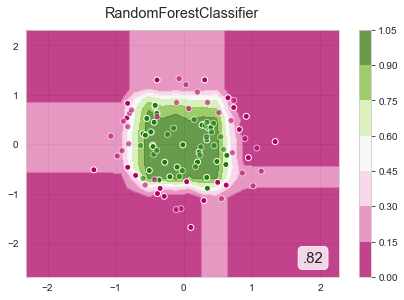

In [62]:
separating_surface(X, y, RandomForestClassifier(random_state=73))

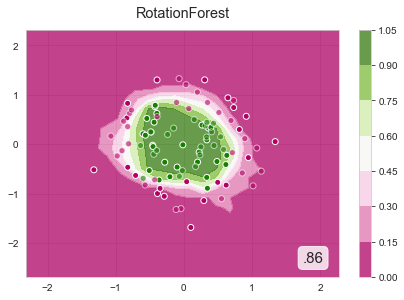

In [66]:
separating_surface(X, y, RotationForest(k_features_subsets=1, random_state=73))

# 3. sMAPE 

In [68]:
def smape(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_true) + np.abs(y_pred)))

# как я понял, ошибка в том, что при нулевых векторах y_true и y_pred метрика возвращает ошибку
def smape2(y_true: np.ndarray, y_pred: np.ndarray):
    if np.allclose(y_true, y_pred, np.zeros((y_true.shape))):
        return 0.0
    return smape(y_true, y_pred)

In [69]:
# нулевые вектора
y_true_z = np.zeros((10))
y_pred_z = y_true_z

# пример из задачи
y_true = np.array([0.5])
y_pred = np.array([50])

Поделим на два для интерпретируемости

In [70]:
print(f"Zeros = {smape2(y_true_z, y_pred_z)/2}")
print(f"0.5 and 50 = {smape2(y_true, y_pred)/2:.2f}")

Zeros = 0.0
0.5 and 50 = 0.98


Напишем тест для проверки метрики на ошибку.

In [71]:
from typing import Callable
def test_zeros(metric: Callable):
    y_true = np.zeros((10))
    y_pred = np.zeros((10))
    assert metric(y_true, y_pred) == 0, "Metric must return 0!"

In [73]:
test_zeros(smape)

AssertionError: Metric must return 0!

In [72]:
test_zeros(smape2)

# 4. Re

In [74]:
import pandas as pd
import numpy as np
import string    
import random
import re
import functools
 

def series_of_ids(n_symbols: int, n_rows: int) -> pd.Series:
    x = pd.Series([
        "".join(random.choices(string.ascii_lowercase + string.digits, k=n_symbols)) 
        for _ in range(n_rows)
    ])
    return x

Напишу декоратор для вычисления среднего времени работы функций

In [75]:
from time import perf_counter

class timeit:
    def __init__(self, N: int):
        self.N = N

    def __call__(self, func: Callable):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            times = []
            for _ in range(self.N):
                start = perf_counter()
                result = func(*args, **kwargs)
                end = perf_counter() - start
                times.append(end)
            wrapper.mean_time = sum(times) / self.N
            return result
        wrapper.mean_time = 0.0
        return wrapper

Сгенерируем данные для проверки

In [76]:
idxs = series_of_ids(10, 100000)

In [77]:
@timeit(10)
def chars_and_digits(x: pd.Series) -> pd.Series:
    y = x.apply(lambda s: re.sub(r"[^a-z]", "", s) + re.sub(r"[^\d]", "", s))
    return y

In [78]:
@timeit(10)
def speedy_chars_and_digits(x: pd.Series) -> pd.Series:
    ascii_lowercase_pattern = re.compile(r'[a-z]')
    digits_pattern = re.compile(r'[0-9]')
    y = x.apply(
        lambda s: 
            "".join(ascii_lowercase_pattern.findall(s) + digits_pattern.findall(s))
    )
    return y

In [80]:
a = chars_and_digits(idxs)
b = speedy_chars_and_digits(idxs)

# проверим одинаковы ли ответы с исходной фукнцией
np.array_equal(a, b)

True

In [81]:
print(f"Speed improvement by {chars_and_digits.mean_time/speedy_chars_and_digits.mean_time:.2f} times.")

Speed improvement by 1.90 times.


# 5. Similar Items Price

In [82]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import seaborn as sns 

Сгенерируем датасет для задания

In [90]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=10, n_targets=1, noise=0.2)
df = pd.DataFrame({
    'price': y, 
    'embedding': tuple(X)
})
df.head()

,price,embedding
0,-41.844367,"[0.05111028821296957, -0.7670158101005915, -0...."
1,129.704442,"[-0.8503086533614014, 0.8458478044894611, 0.01..."
2,-134.742814,"[-0.6157823564003732, 0.8909127330874315, -1.6..."
3,-43.621579,"[0.3750086830218457, 0.7938929238650917, -1.21..."
4,-99.953632,"[-1.099633942558361, -0.08063667250496473, -1...."


In [91]:
# отметить nan 0.2 от выборки
negative_samples = sorted(np.random.choice(df.shape[0], size=200, replace=False))
X_before = df.iloc[negative_samples].copy()
df.loc[negative_samples, 'price'] = np.nan

print(f"NotNAN prices: {df.notna()['price'].sum()}")

NotNAN prices: 800


In [92]:
from sklearn.neighbors import KNeighborsRegressor

def neighbors_price(X: pd.DataFrame, n_neighbors: int = 5) -> pd.DataFrame:
    X = X.copy()
    
    X_train = X.loc[X["price"].notna()]
    X_nan_idx = X.loc[X['price'].isna()].index
    
    X_train_array = X_train['embedding'].values
    X_train_array = np.stack(X_train_array, axis=0)
    
    X_test_array = np.stack(X['embedding'].values, axis=0)
    y_train = X_train['price']
    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    knn.fit(X_train_array, y_train)
    print(knn.score(X_train_array, y_train))
    
    y_pred = knn.predict(X_test_array) 
    y_pred_ser = pd.Series(y_pred[X_nan_idx], index = X_nan_idx)   
    
    X['knn_price'] = y_pred
    X['new_price'] = X['price'].fillna(y_pred_ser)
    
    return X

In [93]:
df_after = neighbors_price(df, n_neighbors=5)

0.8683865620549335


In [94]:
from sklearn.metrics import r2_score

r2_score(X_before['price'], df_after['new_price'][negative_samples])

0.7812246705707228

In [95]:
df_after.head()

,price,embedding,knn_price,new_price
0,-41.844367,"[0.05111028821296957, -0.7670158101005915, -0....",-92.715602,-41.844367
1,129.704442,"[-0.8503086533614014, 0.8458478044894611, 0.01...",77.228923,129.704442
2,-134.742814,"[-0.6157823564003732, 0.8909127330874315, -1.6...",-77.151621,-134.742814
3,-43.621579,"[0.3750086830218457, 0.7938929238650917, -1.21...",-6.100057,-43.621579
4,NaN,"[-1.099633942558361, -0.08063667250496473, -1....",-86.703363,-86.703363


# 6. Stocks

In [96]:
data = pd.DataFrame({
    'sku': [100, 200, 300],
    'gmv': [400, 350, 500],
    'price': [100, 70, 120],
    'stock': [3, 10, 4]
})
data

,sku,gmv,price,stock
0,100,400,100,3
1,200,350,70,10
2,300,500,120,4


In [97]:
def postproc(x: pd.Series) -> pd.Series:
    gmv_pred = x['stock'] * x['price']
    gmv_true = gmv_pred if gmv_pred <= x['gmv'] else x['gmv']
    x['gmv'] = gmv_true

def limit_gmv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.apply(lambda x: postproc(x), axis=1)
    return df

limit_gmv(data)

,sku,gmv,price,stock
0,100,300,100,3
1,200,350,70,10
2,300,480,120,4
